<a href="https://colab.research.google.com/github/Swathi1309/ED18B034_ME18B133_CS6910/blob/main/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
!pip install webcolors

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, TimeDistributed, Lambda, Activation, Reshape,\
Softmax, Multiply, AdditiveAttention, Concatenate, Add, RepeatVector
import tarfile
import random
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import to_categorical

from math import log
from numpy import array, argmax
import sklearn

import matplotlib
from __future__ import unicode_literals
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.display import HTML as html_print
from IPython.display import display

from webcolors import rgb_to_hex

import pprint

In [ ]:
!pip install wandb
!wandb login
import wandb
from wandb.keras import WandbCallback
wandb.init(project="assg3", entity='cs6910_project')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Examples

File extraction

In [ ]:
my_tar = tarfile.open('/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0.tar')
my_tar.extractall('/content/drive/MyDrive/Dakshina dataset') # specify which folder to extract to
my_tar.close()

Examples

In [ ]:
import csv
hi_to_eng = open("/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
read_tsv = csv.reader(hi_to_eng, delimiter="\t")
i=0
for row in read_tsv:
  i +=1
  print(row)
  if i==30:
    break
hi_to_eng.close()

# Loading datasets

In [3]:
def load_data(data_path, data):
  input_texts=[]
  target_texts = []
  global tk_input, tk_target, num_input_tokens, num_target_tokens
  
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[: (len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    
  if (data =="test"):
    global  input_texts_test
    input_texts_test = input_texts
  
  if (data == "train"):
    tk_input = keras.preprocessing.text.Tokenizer(num_words=None, char_level=True)
    tk_input.fit_on_texts(input_texts)
    enc_input = tk_input.texts_to_sequences(input_texts)
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, padding='post')

    tk_target = keras.preprocessing.text.Tokenizer(num_words=None, char_level=True)
    tk_target.fit_on_texts(target_texts)
    dec_target = tk_target.texts_to_sequences(target_texts)
    dec_target = tf.keras.preprocessing.sequence.pad_sequences(dec_target, padding='post')

    dec_input = np.zeros(dec_target.shape)
    dec_input[:,:(dec_target.shape[1]-1)] = dec_target[:,1:]
  
  else:  
    enc_input = tk_input.texts_to_sequences(input_texts)
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, padding='post', maxlen = max_input_length)

    dec_target = tk_target.texts_to_sequences(target_texts)
    dec_target = tf.keras.preprocessing.sequence.pad_sequences(dec_target, padding='post', maxlen = max_target_length)

    dec_input = np.zeros(dec_target.shape)
    dec_input[:,:(dec_target.shape[1]-1)] = dec_target[:,1:]
  
  return enc_input, dec_target, dec_input

In [4]:
data_path_train = "/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
data_path_dev = '/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
data_path_test = '/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

global enc_input_train, dec_input_train, dec_target_train, enc_input_dev, dec_input_dev, dec_target_dev
global tk_input, tk_target, reverse_input_char_index, reverse_target_char_index
global input_token_train, output_token_train, max_input_length, max_target_length
global y_true_dev, y_true_train
global classes
global input_texts_test

# Loading datasets
enc_input_train, dec_input_train, dec_target_train = load_data(data_path_train,'train')

max_input_length = enc_input_train.shape[1]
max_target_length = dec_target_train.shape[1]

num_input_tokens = len(tk_input.word_index)+1
num_target_tokens = len(tk_target.word_index)+1

enc_input_dev, dec_input_dev, dec_target_dev = load_data(data_path_dev,'dev')
enc_input_test, dec_input_test, dec_target_test = load_data(data_path_test,'test')

# One hot encoding of target outputs
y_true_dev = np.zeros((dec_target_dev.shape[0],dec_target_dev.shape[1], num_target_tokens))
for i in range(0,dec_target_dev.shape[0]):
  y_true_dev[i] = to_categorical(dec_target_dev[i], num_classes = num_target_tokens)

y_true_train = np.zeros((dec_target_train.shape[0],dec_target_train.shape[1], num_target_tokens))
for i in range(0,dec_target_train.shape[0]):
  y_true_train[i] = to_categorical(dec_target_train[i], num_classes = num_target_tokens)

# Integer to character dictionary
reverse_input_char_index = dict((i, char) for char, i in tk_input.word_index.items())
reverse_target_char_index = dict((i, char) for char, i in tk_target.word_index.items())

# Defining classes
classes = ["0"]
for i in range(1,29):
  classes.append(reverse_target_char_index[i])

# Defining functions

Training models

In [53]:
# Encoder
def encoder(enc_out,enc_block, latent_dim, enc_layers):
  states = []
  for i in range(0,enc_layers):
    if enc_block =='LSTM':
      enc_out ,h ,c = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      s = [h,c]
      states.append(s)
    elif enc_block =='GRU':
      enc_out ,s = GRU(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      states.append(s)
    else:
      enc_out ,s = SimpleRNN(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      states.append(s)
    
  return enc_out,states

# Decoder
def decoder(X_input_dec, hs_init, latent_dim, dec_block, dec_layers, dense_no, drop_no, attn):
  out_dec = X_input_dec
  hs = hs_init
  for i in range (0,dec_layers):
    if i == 0 and attn == True:
      hs[i] = None
    if dec_block == 'LSTM':
      out_dec, h, s = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    elif dec_block == 'GRU':
      out_dec, _ = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    else:
      out_dec, _ = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
  
  if dense_no != 0:
    out_dec = TimeDistributed(Dense(dense_no, activation="relu", name = 'output'), name = 'dense_hidden')(out_dec)
    out_dec = Dropout(drop_no)(out_dec)
  out_dec = TimeDistributed(Dense(num_target_tokens, activation="softmax", name = 'output'), name = 'dense')(out_dec)
  
  return out_dec

def decoder_new(X_input_dec, hs_init, latent_dim, dec_block, dec_layers, dense_no, drop_no, attn):
  out_dec = X_input_dec
  hs = hs_init
  for i in range (0,dec_layers):
    if dec_block == 'LSTM':
      out_dec, h, s = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    elif dec_block == 'GRU':
      out_dec, _ = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    else:
      out_dec, _ = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
  return out_dec

# Bahnadau Attention
def b_attention(latent_dim):
  query_in = keras.Input((max_target_length,latent_dim))
  values_in = keras.Input((max_input_length,latent_dim))
  # query_mask = tf.ones(tf.shape(query)[:-1], dtype= bool)
  # value_mask = mask
  # query = Reshape((1,latent_dim), name='query_reshape')(query_in)
  score_unit2 = Dense(num_target_tokens, name='score_unitq')(query_in)
  score_unit1 = Dense(num_target_tokens, name='score_unitv')(values_in)
  context_vector, attention_weights = tf.keras.layers.AdditiveAttention()([score_unit2, score_unit1], return_attention_scores = True)
  # score_unit12 = Add()([score_unit1, score_unit2])
  # score_unit12 = Activation('tanh')(score_unit12)
  # score = Dense(1)(score_unit12)
  # attention_weights = Softmax(axis=1)(score)
  # context_vector = Multiply()([attention_weights,values_in])
  # context_vector = Lambda(lambda x: tf.reduce_sum(x,axis=1))(context_vector)
  # context_vector = RepeatVector(max_target_length)(context_vector)

  model = Model(inputs = [query_in,values_in], outputs = [context_vector, attention_weights], name='attention')
  return model

# Final RNN model for training
def RNN_model(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))
  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)
  _,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  out_dec = decoder(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no, False)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')
  return model

# Final RNN model with attention for training
def RNN_w_att(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))

  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)

  values,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  context_vector, weights = b_attention(latent_dim)([s_init[len(s_init)-1][0], values])
  X_dec = Concatenate(name = 'concatenate')([context_vector,X_dec])

  out_dec = decoder(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no, True)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')

  return model

def RNN_w_att_new(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))

  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)

  out_enc ,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  # context_vector, weights = b_attention(latent_dim)([s_init[len(s_init)-1][0], values])
  # X_dec = Concatenate(name = 'concatenate')([context_vector,X_dec])

  out_dec = decoder_new(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no, True)
  context_vector, weights = b_attention(latent_dim)([out_dec, out_enc])
  out_dec = Concatenate(name = 'concatenate')([context_vector,out_dec])
  dense_layer = Dense(num_target_tokens, activation="softmax", name = 'dense')
  out_dec = TimeDistributed(dense_layer, name = 'time_dis')(out_dec)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')

  return model

Inference models

In [54]:
# Encoder model for inference
def enc_inference(model,enc_layers,rnn_block):
  X_enc = model.input[0]
  X_in_enc = model.get_layer('embedding_enc')(X_enc)
  enc_outputs = X_in_enc
  states = []
  if rnn_block == 'LSTM':
    for i in range(0,enc_layers):
      enc_outputs, h_enc, s_enc = model.get_layer('encoder'+str(i))(enc_outputs)
      states.append([h_enc, s_enc])
  else:
    for i in range(0,enc_layers):
      enc_outputs, s_enc = model.get_layer('encoder'+str(i))(enc_outputs)
      states.append(s_enc)
  
  enc_model = keras.Model(inputs = X_enc, outputs = [enc_outputs, states])
  return enc_model

# Decoder model for inference
def dec_inference(model, latent_dim, dec_layers, rnn_block, attn, embedding_dim):
  # if attn==True:
  #   dec_inputs = keras.Input(shape=(max_target_length, latent_dim+embedding_dim))
  #   dec_outputs = dec_inputs
  # else:
  dec_inputs = model.input[1]
  dec_outputs = model.get_layer('embedding_dec')(dec_inputs)
  hs_inputs = []
  
  if rnn_block == 'LSTM':
    for i in range(0,dec_layers):
      h = keras.Input(shape=(latent_dim,))
      c = keras.Input(shape=(latent_dim,))
      hs_inputs.append([h,c])
    hs_outputs = []
    for i in range(0,dec_layers):
      # if i == 0 and attn == True:
      #   dec_outputs, h_dec, s_dec = model.get_layer('decoder'+str(i))(dec_outputs)
      #   hs_outputs.append([h_dec,s_dec])
      # else:
      dec_outputs, h_dec, s_dec = model.get_layer('decoder'+str(i))(dec_outputs, initial_state = hs_inputs[i])
      hs_outputs.append([h_dec,s_dec])

  else:
    for i in range(0,dec_layers):
      c = keras.Input(shape=(latent_dim,))
      hs_inputs.append(c)
    hs_outputs = []
    for i in range(0,dec_layers):
      dec_outputs, s_dec = model.get_layer('decoder'+str(i))(dec_outputs, initial_state = hs_inputs[i])
      hs_outputs.append(s_dec)

  # dec_dense = model.get_layer('dense')
  # dec_outputs = dec_dense(dec_outputs)
  dec_model = keras.Model(inputs = [dec_inputs, hs_inputs], outputs = [dec_outputs, hs_outputs])  
  return dec_model

Decoder functions for model without attention

In [9]:
# Greedy decoder
def greedy_decoder(enc_inf, dec_inf, input_seq, rnn_block):
  _, states = enc_inf.predict(input_seq)
  target_seq = np.zeros((input_seq.shape[0],1))
  target_seq[:,0] = tk_target.word_index["\t"]
  pred = [[tk_target.word_index["\t"]] for _ in range (input_seq.shape[0])]
  
  if rnn_block == 'LSTM':
    for i in range(max_target_length):
      output_tokens, state_final = dec_inf.predict([target_seq, states])
      x = np.argmax(output_tokens, axis=-1)
      target_seq = x
      for j in range(input_seq.shape[0]):
        pred[j].append(target_seq[j][0])
      states = state_final

  else:
    for i in range(max_target_length):
      output_tokens, c = dec_inf.predict([target_seq, states])
      x = np.argmax(output_tokens, axis=-1)
      target_seq = x
      for j in range(input_seq.shape[0]):
        pred[j].append(target_seq[j][0])
      states = c

  return pred

# Beam search function
def beam_search(enc_inf, dec_inf, input_seq, k):
  _, states = enc_inf.predict(input_seq)
  target_seq = np.zeros((k,1))
  target_seq[:,0] = tk_target.word_index["\t"]
  pred = [[[tk_target.word_index["\t"]], 0.0] for _ in range (k)]

  for i in range(max_target_length):
    all_candidates = list()
    output_tokens, state_final = dec_inf.predict([target_seq, states])
    states = state_final
    for j in range(len(pred)):
      seq, score = pred[j]
      for l in range(output_tokens.shape[-1]):
        candidate = [seq + [l], score - log(output_tokens[j][0][l])]
        all_candidates.append(candidate)
      if i==0:
        break
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    pred = ordered[:k]
    for j in range (k):
      target_seq[j] = pred[j][0][i+1]

  final_pred = ordered[:1]
  return (final_pred[0][0])

# Beam search decoder
def beam_search_decoder(enc_inf, dec_inf, input_seq, k):
  pred = []
  for i in range(input_seq.shape[0]):
    input = input_seq[i:i+1,:]
    input = np.concatenate((input,)*k, axis = 0)
    pred.append(beam_search(enc_inf, dec_inf, input, k))
    if i%100 == 0:
      print((i/input_seq.shape[0])*100)
  return pred

Decoder function for model with attention

In [55]:
# Greedy decoder for model with attention
def greedy_decoder_attn(enc_inf, dec_inf, att_inf, dense, input_seq):
  output_enc, s_init = enc_inf.predict(input_seq)
  target_seq = np.zeros((input_seq.shape[0],22))
  target_seq[:,0] = tk_target.word_index["\t"]

  pred = [[tk_target.word_index["\t"]] for _ in range (input_seq.shape[0])]
  attention_weights = [[] for _ in range(input_seq.shape[0])]
  for i in range(max_target_length-1):
    # context_vector, weights = att_inf.predict([s_init[len(s_init)-1][0], values])
    # output_tokens = Concatenate()([context_vector, model.get_layer('embedding_dec')(target_seq)])
    #print (len(s_init))
    output_dec, state_final = dec_inf.predict([target_seq, s_init])
    context_vector, weights = att_inf.predict([output_dec, output_enc])
    output_dec = Concatenate(name = 'concatenate')([context_vector,output_dec])
    output_dec = dense.predict(output_dec)
    x = np.argmax(output_dec[:,0,:], axis = -1)
    for j in range(input_seq.shape[0]):
      attention_weights[j].append(weights[j])
      target_seq[j][0] = x[j]
      pred[j].append(target_seq[j][0])
    s_init = state_final

  return pred, attention_weights

Word accuracy metric

In [11]:
def word_accuracy(true_words, pred_words):
  count = len([i for i, j in zip(true_words, pred_words) if i==j])
  return count/len(pred_words)

Encoding to Word conversion

In [56]:
def transliteration(inputs):
  start = tk_target.word_index["\t"]
  end = 0
  words = []
  for i in range(len(inputs)):
    start_index = inputs[i].index(start)
    try:
      end_index = inputs[i].index(end)
      temp = inputs[i][start_index+1:end_index]
    except ValueError:
      temp = inputs[i][start_index+1:]
    word = list(map(reverse_target_char_index.__getitem__, temp))
    # if (word[-1]=="\n"):
    #   word.pop(-1)
    separator = ''
    word_new = separator.join(word)
    words.append(word_new)
  return words

# Sweeps

In [ ]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    'embedding_no':{
        'values': [512]
      },
    'rnn_block':{
        'values': ['LSTM']
      },
    'no_of_layers': {
        'values': [2]
      },
    'latent_dimension': {
        'values': [512]
      },
    'hidden_layer': {
        'values': [0]
      },
    'dropout': {
        'values': [0]
      },
    'beam_search': {
        'values': [4, 2]
      },
    'epochs' : {
        'values' : [20]
      },
    'optimizer' : {
        'values' : ['rmsprop']
      },
    'learning_rate' : {
        'values' : [1e-3]
      },
    'attention' : {
        'values' : [False]
    }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

def training_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        if config.attention == True:
          model = RNN_w_att(config.embedding_no, config.rnn_block, config.latent_dimension, config.rnn_block,
                            config.hidden_layer, config.dropout, config.no_of_layers, config.no_of_layers)
        else:
          model = RNN_model(config.embedding_no, config.rnn_block, config.latent_dimension, config.rnn_block,
                            config.hidden_layer, config.dropout, config.no_of_layers, config.no_of_layers)
        
        if config.optimizer == 'adam':
          opt = Adam(config.learning_rate)
        else:
          opt = RMSprop(config.learning_rate)
        model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

        # #model.fit([enc_input_train,dec_input_train], y_true_train, 
        #                     epochs=config.epochs,
        #                     validation_data = ([enc_input_dev,dec_input_dev], y_true_dev),
        #                     callbacks = [WandbCallback()]
        #                     )

        name = str(config.rnn_block) + '_' + str(config.no_of_layers) + '_' + str(config.embedding_no) + '_' + str(config.latent_dimension) + '_' + str(config.hidden_layer) + '_' + str(config.epochs)
        location = '/content/drive/MyDrive/Transliteration/' + name
        model.save(location)

        enc_inf = enc_inference(model, config.no_of_layers, config.rnn_block)
        dec_inf = dec_inference(model, config.latent_dimension, config.no_of_layers, config.rnn_block, config.attention, config.embedding_no)

        if (config.beam_search!=0):
          predictions = beam_search_decoder(enc_inf, dec_inf, enc_input_dev, config.beam_search)
        else:
          predictions = greedy_decoder(enc_inf, dec_inf, enc_input_dev, config.rnn_block)

          # word_acc = word_accuracy(dec_target_dev,np.array(predictions))
          # word_acc = sklearn.metrics.accuracy_score(dec_target_dev,np.array(predictions))
          pred_words = transliteration(predictions)

          true = list(list(dec_input_dev[i]) for i in range(dec_input_dev.shape[0]))
          true_words = transliteration(list(true))
          word_acc = word_accuracy(true_words, pred_words)
          wandb.log({'word_level_accuracy': word_acc})

{'method': 'grid',
 'parameters': {'attention': {'values': [False]},
                'beam_search': {'values': [4, 2]},
                'dropout': {'values': [0]},
                'embedding_no': {'values': [512]},
                'epochs': {'values': [20]},
                'hidden_layer': {'values': [0]},
                'latent_dimension': {'values': [512]},
                'learning_rate': {'values': [0.001]},
                'no_of_layers': {'values': [2]},
                'optimizer': {'values': ['rmsprop']},
                'rnn_block': {'values': ['LSTM']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="assg3")
wandb.agent(sweep_id, training_sweep)

# Plotting confusion matrix

In [ ]:
def labels(true_words, pred_words):
  true = []
  pred = []
  for i in range(len(true_words)):
    word1 = true_words[i]
    word2 = pred_words[i]
    len1 = len(word1)
    len2 = len(word2)
    
    for letter1 in word1:
      true.append(tk_target.word_index[letter1])
    for letter2 in word2:
      pred.append(tk_target.word_index[letter2])
    
    if len1<len2:
      for i in range(len2-len1):
        true.append(0)
    if len1>len2:
      for i in range(len1-len2):
        pred.append(0)

  return true, pred

def confusion_matrix(true, pred):
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None, y_true=true, preds=pred, class_names=classes)})

In [ ]:
true, pred = labels(true_words, pred_words)
confusion_matrix(true,pred)

# Plotting attention heatmaps

In [34]:
def plot_attention(attention, input_word, predicted_word):
  attention = np.squeeze(np.array(attention))
  attention = attention[:len(pred), :len(word)]
  print(attention)
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='gray')
  fontdict = {'fontsize': 14}

  # ax.set_xticklabels([''] + list(input_word), rotation=90)
  ax.set_yticklabels([''] + list(predicted_word))

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

[[0.0508038  0.04413418 0.05641566 0.05467202 0.09866309 0.08606511]
 [0.05402971 0.05350355 0.05003623 0.05400358 0.05536891 0.06072669]
 [0.0524793  0.05195529 0.04835194 0.05434309 0.05528458 0.05932211]
 [0.05274796 0.05282091 0.0481494  0.05417814 0.05395304 0.05868738]
 [0.05342124 0.0526874  0.04819642 0.05464876 0.05482593 0.06053482]
 [0.05173106 0.05183716 0.04801757 0.05390094 0.05206722 0.05641551]
 [0.05229153 0.05233833 0.04877512 0.05442314 0.05296794 0.05806017]
 [0.0522453  0.05271896 0.04844441 0.05357357 0.05076627 0.05573123]
 [0.05226607 0.05217507 0.0484735  0.05409186 0.05234709 0.05702383]]


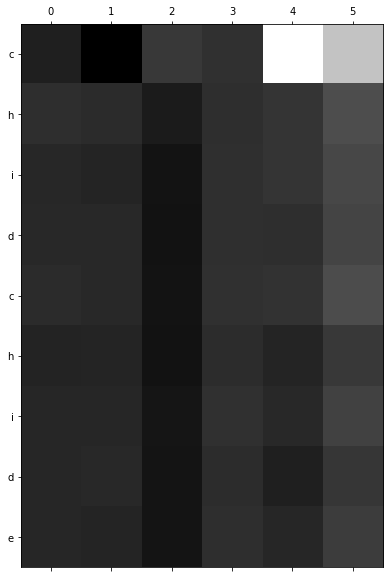

In [75]:
num = np.random.randint(0, len(input_texts_test))
word = input_texts_test[num]
pred = pred_words[num]
weight = weights[num]
plot_attention(weight, word, pred)

# Visualization

In [77]:
def cstr(s, color='black', indent = False):
	if s == '':
		return "<text style=color:#000;font-family:verdana;padding-left:30px;background-color:{}> </text>".format(color, s)   #position:relative;
	else:
		return "<text style=color:#000;font-family:verdana;background-color:{}>{} </text>".format(color, s)

def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))
 
def grad_color(value):
  gb = int(value*510)
  hex_color = rgb_to_hex((255,255-gb,255-gb))
  return hex_color

def final_vis(attention_weights, input_word, output_word):
  input_word_list = list(input_word)
  output_word_list = list(output_word)
  # Let output_values be of shape (num_tokens_output_word,num_tokens_input_word)
  # Print the input with the colour fills
  for i in range(len(output_word_list)):  # For each word
    text_colours = []
    for j in range(len(input_word_list)):
      text = (input_word_list[j], grad_color(attention_weights[i][j]))
      text_colours.append(text)
    print_color(text_colours)
    print(''.join(output_word_list[0:i]) + "\033[4m" + output_word_list[i] + "\033[0m" + ''.join(output_word_list[i+1:]))
    print('  ')

In [ ]:
# num = np.random.randint(0, len(input_texts_test))
word = input_texts_test[num]
pred = pred_words[num]
weight = weights[num]
final_vis(weight, word, pred)

# Saving Predictions

# Rest of the code

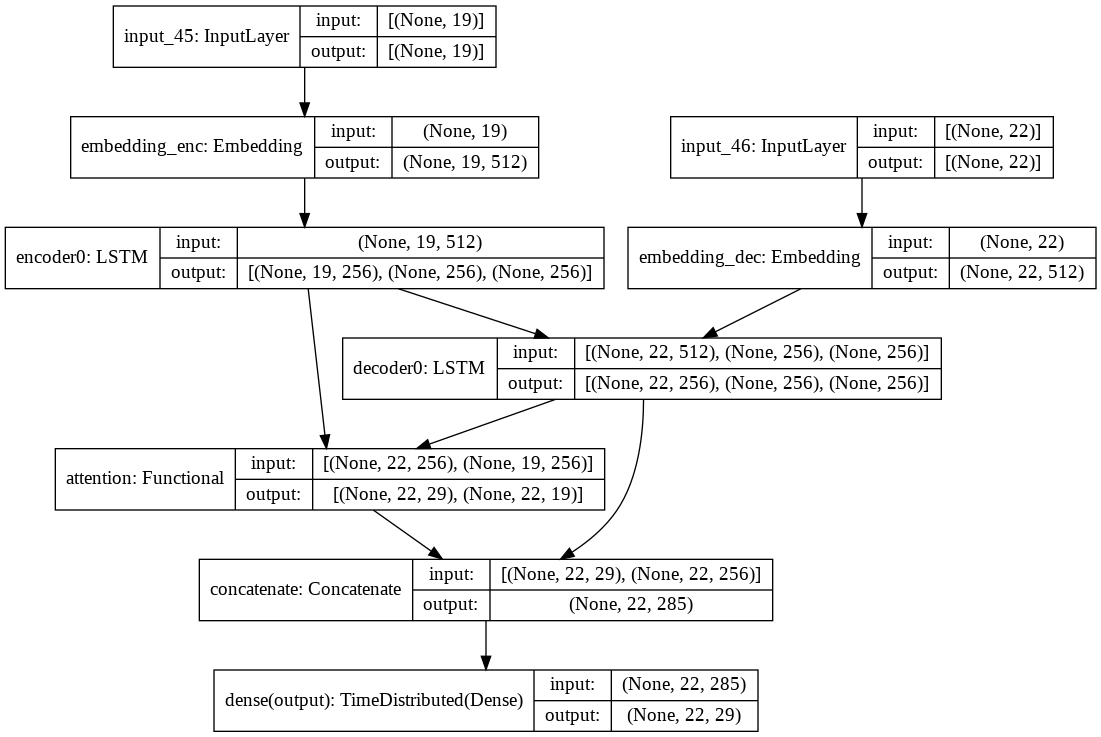

In [57]:
model = RNN_w_att_new(512, 'LSTM', 256, 'LSTM', 0,0,1,1)
keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.compile(optimizer=RMSprop(1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])
model.fit([enc_input_train,dec_input_train], y_true_train, batch_size = 128,epochs=20, validation_data=([enc_input_dev,dec_input_dev], y_true_dev))

In [60]:
enc_inf = enc_inference(model, 1,'LSTM')
dec_inf = dec_inference(model, 256, 1, 'LSTM', True, 512)
att_inf = model.get_layer('attention')
dense = model.get_layer('output')

predictions, weights = greedy_decoder_attn(enc_inf, dec_inf, att_inf, dense, enc_input_dev)

pred_words = transliteration(predictions)

true = list(list(dec_input_test[i]) for i in range(dec_input_test.shape[0]))
true_words = transliteration(list(true))
word_acc = word_accuracy(true_words, pred_words)

ValueError: ignored

In [ ]:
pred_words[0:10]

In [ ]:
true_words[0:10]

In [ ]:
word_acc

In [ ]:
att_model = b_attention(256)
keras.utils.plot_model(att_model,show_shapes=True, rankdir='TB')

In [ ]:
model = RNN_model(512, 'LSTM', 512, 'LSTM', 0, 0, 2, 2)
keras.utils.plot_model(model,show_shapes=True, rankdir='TB')

In [ ]:
enc_inf = enc_inference(model, 2, "LSTM")
dec_inf = dec_inference(model, 512, 2, 'LSTM', False, 512)

predictions = greedy_decoder(enc_inf, dec_inf, enc_input_dev[0:10])

pred_words = transliteration(predictions)
true = list(list(dec_input_dev[i]) for i in range(dec_input_dev.shape[0]))
true_words = transliteration(list(true))
word_acc = word_accuracy(true_words, pred_words)

In [ ]:
list_input = list(tk_input.word_index.keys())
input_word_list = random.sample(list_input,8)
print(input_word_list)

In [ ]:
output_values = np.random.uniform(size=(5,8))
output_word_list = list('nocul')
final_vis(output_values, input_word_list, output_word_list)